**Importing dependencies**

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

TensorFlow 2.x selected.


**Getting data**

Using the automobile miles per gallon dataset from UCI.

In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 1us/step


**Preparing the data**



In [3]:
# prepare the volumn names and then load the entire dataset as a pandas dataframe
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

# create a copy of the dataset for further work
dataset = raw_dataset.copy()
dataset.tail()

# Remove NaN values
dataset = dataset.dropna()

# change the origin column from categorical to one-hot
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


**Train and test split**

Performing an 80-20 split for train and test. Also dropping the MPG column from the set as it contains our output labels.

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

              count         mean         std  ...     50%      75%     max
Cylinders     314.0     5.477707    1.699788  ...     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589  ...   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214  ...    94.5   128.00   225.0
Weight        314.0  2990.251592  843.898596  ...  2822.5  3608.00  5140.0
Acceleration  314.0    15.559236    2.789230  ...    15.5    17.20    24.8
Model Year    314.0    75.898089    3.675642  ...    76.0    79.00    82.0
USA           314.0     0.624204    0.485101  ...     1.0     1.00     1.0
Europe        314.0     0.178344    0.383413  ...     0.0     0.00     1.0
Japan         314.0     0.197452    0.398712  ...     0.0     0.00     1.0

[9 rows x 8 columns]


**Normalizing the data**

In [0]:
def normalize(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

**Creating the model**

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
  tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
  tf.keras.layers.Dense(units=1)
])

**Compiling the model**

In [0]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))

**Training**

Using early stopping to stop the training once validation loss doesn't reduce for 10 epochs. For this we pass the validation data to the fit method using the `validation_data` keyword argument.

In [0]:
model_history = model.fit(normed_train_data, train_labels, validation_data=(normed_test_data, test_labels), epochs=1000, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

**Plotting the performance metrics**

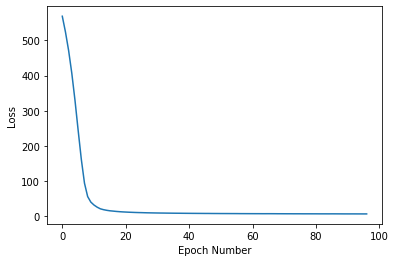

In [9]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(model_history.history['loss'])

**Predictions**

In [10]:
test_predictions = model.predict(normed_test_data).flatten()
for index, value in zip(range(10), test_labels):
  print("Predicted value: {}, Actual value: {}".format(test_predictions[index], value))

Predicted value: 15.853302955627441, Actual value: 15.0
Predicted value: 10.663589477539062, Actual value: 10.0
Predicted value: 11.821334838867188, Actual value: 9.0
Predicted value: 23.715681076049805, Actual value: 25.0
Predicted value: 20.72786521911621, Actual value: 19.0
Predicted value: 13.212379455566406, Actual value: 14.0
Predicted value: 13.567712783813477, Actual value: 14.0
Predicted value: 13.049249649047852, Actual value: 13.0
Predicted value: 19.595584869384766, Actual value: 18.0
Predicted value: 29.928693771362305, Actual value: 35.0
